In [1]:
from file_processors import histogram_reader, table_writer
from feature_generators import ae_extractor, pca_extractor, tsne_embedder, dbscan_clusterer
from plotters import embedding_plotter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf
from IPython.display import display, clear_output
from ipywidgets import widgets, HBox, VBox, Layout
import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('steven-space.mplstyle')

In [3]:
# Define file paths
data_path = "../datasets"
encoders_path = "../encoders"
properties_file = f"{data_path}/properties-input-Full.csv"
ae_model_2d = f"{encoders_path}/XAE-ENCODER-2D-CNN-cn[32, 16]-fc[192, 48]-neck12-lr0.001-b1024-reg0.0-botreg0.1-kernhe_normal-xae-rs505.h5"
ae_model_3d = f"{encoders_path}/XAE-ENCODER-3D-FC-fc[1536, 384, 96]-neck24-lr0.001-b1024-reg0.1-xae24.h5"

# Widgets
int_text_layout = Layout(width='159px')
histogram_representation_widget = widgets.Dropdown(
    options=["2D", "3D"],
    value="2D",
    description="Histogram Representation:",
    disabled=False,
    style={'description_width': 'initial'}
)

feature_extractor_widget = widgets.Dropdown(
    options=["PCA", "AE"],
    value="PCA",
    description="Feature Extractor:",
    disabled=False,
    style={'description_width': 'initial'}
)

n_pca_widget = widgets.IntSlider(
    value=2, min=2, max=100, step=1, 
    description="PCA Components:", 
    disabled=False, continuous_update=False, 
    readout=True, readout_format='d',
    style={'description_width': 'initial'}
)

latent_size_message = widgets.HTML(
    value="",
    placeholder='',
    description="AE Components:",disabled=False, 
    style={'description_width': 'initial'}
)

tsne_perp_widget = widgets.IntText(
    value=30, description="Perplexity:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_lr_widget = widgets.IntText(
    value=100, description="Learning Rate:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_iter_widget = widgets.IntText(
    value=2000, description="Iterations:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_rs_widget = widgets.IntText(
    value=11, description="Random State:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_ee_widget = widgets.IntText(
    value=1, description="Early Exaggeration:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_init_widget = widgets.Dropdown(
    options=["random", "pca"], value="random", 
    description="Initialization:", disabled=False, 
    style={'description_width': 'initial'},
    layout=int_text_layout
)

# Container for t-SNE widgets
tsne_widgets_container = HBox([tsne_perp_widget, tsne_lr_widget, tsne_iter_widget, tsne_rs_widget, tsne_ee_widget, tsne_init_widget])

# Modify the container to include the n_pca_widget and the text message
widgets_container = HBox([histogram_representation_widget, feature_extractor_widget, n_pca_widget, latent_size_message])


# Event handler for changes in both histogram representation and feature extractor
def on_selection_change(change):
    # Clear previous output
    clear_output(wait=True)
    display(widgets_container)
    display(tsne_widgets_container)

    # Extract the current selections
    histogram_representation = histogram_representation_widget.value
    feature_extractor = feature_extractor_widget.value

    # Set default values for n_pca_widget based on histogram representation
    if histogram_representation == '2D':
        n_pca_widget.value = 15
    elif histogram_representation == '3D':
        n_pca_widget.value = 22

    # Set default values for t-SNE widgets based on both selections
    if feature_extractor == 'PCA':
        n_pca_widget.layout.display = 'flex'  # Show PCA container
        latent_size_message.layout.display = 'none' 
        if histogram_representation == '2D':
            tsne_perp_widget.value = 30
            tsne_lr_widget.value = 80
            tsne_iter_widget.value = 4500
            tsne_rs_widget.value = 11
        elif histogram_representation == '3D':
            tsne_perp_widget.value = 50
            tsne_lr_widget.value = 120
            tsne_iter_widget.value = 3500
            tsne_rs_widget.value = 11
    elif feature_extractor == 'AE':
        n_pca_widget.layout.display = 'none'  # Hide PCA container
        latent_size_message.layout.display = 'flex' 
        if histogram_representation == '2D':
            tsne_perp_widget.value = 40
            tsne_lr_widget.value = 100
            tsne_iter_widget.value = 3000
            tsne_rs_widget.value = 12
            latent_size_message.value = "12"
        elif histogram_representation == '3D':
            tsne_perp_widget.value = 60
            tsne_lr_widget.value = 180
            tsne_iter_widget.value = 2000
            tsne_rs_widget.value = 12
            latent_size_message.value = "24"

# Attach the event handler to both widgets
histogram_representation_widget.observe(on_selection_change, names='value')
feature_extractor_widget.observe(on_selection_change, names='value')
# Call the handler once to initialize with the current selections
on_selection_change({'new': feature_extractor_widget.value})

In [4]:
# Create name for features 
if feature_extractor_widget.value == "AE":
    name_features = f"{histogram_representation_widget.value}{feature_extractor_widget.value}{latent_size_message.value}"
elif feature_extractor_widget.value == "PCA":
    name_features = f"{histogram_representation_widget.value}{feature_extractor_widget.value}{n_pca_widget.value}"

# Create name for embeddings
name_embedding = f"perp{tsne_perp_widget.value}-lr{tsne_lr_widget.value}-iter{tsne_iter_widget.value}-rs{tsne_rs_widget.value}-ee{tsne_ee_widget.value}-init{tsne_init_widget.value}"

# Select appropriate histogram file
if feature_extractor_widget.value == "PCA":
    if histogram_representation_widget.value == "2D":
        histogram_file = glob.glob(f"{data_path}/hist{histogram_representation_widget.value}*none*")[0]
    elif histogram_representation_widget.value == "3D":
        histogram_file = glob.glob(f"{data_path}/hist{histogram_representation_widget.value}*none*")[0]
elif feature_extractor_widget.value == "AE":
    if histogram_representation_widget.value == "2D":
        histogram_file = glob.glob(f"{data_path}/hist{histogram_representation_widget.value}*minmax*")[0]
    elif histogram_representation_widget.value == "3D":
        histogram_file = glob.glob(f"{data_path}/hist{histogram_representation_widget.value}*minmax*")[0]
print("Selected Histogram Representation File: ", histogram_file)

# Process histogram file and properties table
histograms, df_properties, ids = histogram_reader.histogram_reader(histogram_file,properties_file, feature_extractor_widget.value)

Selected Histogram Representation File:  ../datasets/hist2D-Full-nE16-nt24-normnone.pkl


In [5]:
# Extract features from histograms
if feature_extractor_widget.value == "PCA":
        features = pca_extractor.pca_extractor(histograms, int(n_pca_widget.value))
elif feature_extractor_widget.value == "AE":
    if histogram_representation_widget.value == "2D":
        features = ae_extractor.ae_extractor(histograms, ae_model_2d)
    elif histogram_representation_widget.value == "3D":
        features = ae_extractor.ae_extractor(histograms, ae_model_3d)

# Create t-SNE embedding and save it to a file
embedding = tsne_embedder.tsne_embedder(features, perplexity=tsne_perp_widget.value, learning_rate=tsne_lr_widget.value, early_exaggeration=tsne_ee_widget.value, iterations=tsne_iter_widget.value, random_state=tsne_rs_widget.value, dimensions=2, init=tsne_init_widget.value)
tsne_file_name = f"{data_path}/tsne_{name_features}_{name_embedding}.csv"
df_tsne = table_writer.embedding_writer(embedding, ids)
df_tsne.to_csv(tsne_file_name, index=False)
print("t-SNE embedding saved to: ", tsne_file_name)

KeyboardInterrupt: 

In [6]:
# Widgets
tsne_files = glob.glob(f"{data_path}/tsne*")
tsne_file_widget = widgets.Dropdown(options=tsne_files, description="t-SNE File:", disabled=False, style={'description_width': 'initial'})
dbscan_eps_widget = widgets.FloatSlider(value=0.5, min=0.1, max=5.0, step=0.1, description="Epsilon:", disabled=False, continuous_update=False, readout=True, readout_format='.1f', style={'description_width': 'initial'})
dbscan_min_samples_widget = widgets.IntSlider(value=5, min=1, max=50, step=1, description="Min Samples:", disabled=False, continuous_update=False, readout=True, readout_format='d', style={'description_width': 'initial'})
dbscan_widget_container = HBox([tsne_file_widget, dbscan_eps_widget, dbscan_min_samples_widget])

# Event handler for changes in both histogram representation and feature extractor
def on_selection_change2(change):
    # Clear previous output
    clear_output(wait=True)
    display(dbscan_widget_container)

    # Extract the current selections
    tsne_file = tsne_file_widget.value

    # Set default values for n_pca_widget based on histogram representation
    if "2DPCA" in tsne_file:
        dbscan_eps_widget.value = 2.8
        dbscan_min_samples_widget.value = 26
    elif "3DPCA" in tsne_file:
        dbscan_eps_widget.value = 2.1
        dbscan_min_samples_widget.value = 23
    elif "2DAE" in tsne_file:
        dbscan_eps_widget.value = 1.6
        dbscan_min_samples_widget.value = 25
    elif "3DAE" in tsne_file:
        dbscan_eps_widget.value = 1.9
        dbscan_min_samples_widget.value = 24

# Attach the event handler to both widgets
tsne_file_widget.observe(on_selection_change2, names='value')
# Call the handler once to initialize with the current selections
on_selection_change2({'new2': tsne_file_widget.value})

In [7]:
# Load t-SNE file
df_tsne = pd.read_csv(tsne_file_widget.value)

# Cluster embeddings with DBSCAN and save it to a file
cluster_labels = dbscan_clusterer.dbscan_clusterer(df_tsne, epsilon=dbscan_eps_widget.value, min_samples=dbscan_min_samples_widget.value)
df_dbscan = table_writer.clustering_writer(df_tsne, cluster_labels)
name_clustering = f"eps{dbscan_eps_widget.value}-ms{dbscan_min_samples_widget.value}"
dbscan_file_name = f"{data_path}/dbscan_{name_features}_{name_embedding}_{name_clustering}.csv"
df_dbscan.to_csv(dbscan_file_name, index=False)

In [9]:
# Widgets
dbscan_files = glob.glob(f"{data_path}/dbscan*")
dbscan_file_widget = widgets.Dropdown(options=dbscan_files, description="DBSCAN File:", disabled=False, style={'description_width': 'initial'})
property_columns = df_properties.columns[2:]
colorcode_property_widget = widgets.Dropdown(options=property_columns, description="Property:", disabled=False, style={'description_width': 'initial'})

bonafide_folder = f"../bonafide_anomalies"
flare_files = list(glob.glob(f"{bonafide_folder}/*flares*.json"))
flare_files.append(None)
dip_files = list(glob.glob(f"{bonafide_folder}/*dips*.json"))
dip_files.append(None)

flares_widget = widgets.Dropdown(options=flare_files, value = None, description="Bonafide Flares Files:", disabled=False, style={'description_width': 'initial'})
dips_widget = widgets.Dropdown(options=dip_files, value = None, description="Bonafide Dips Files:",disabled=False,style={'description_width': 'initial'})

plot_widget_container = HBox([dbscan_file_widget, colorcode_property_widget])
bonafide_widget_container = HBox([flares_widget, dips_widget])
display(plot_widget_container)
display(bonafide_widget_container)

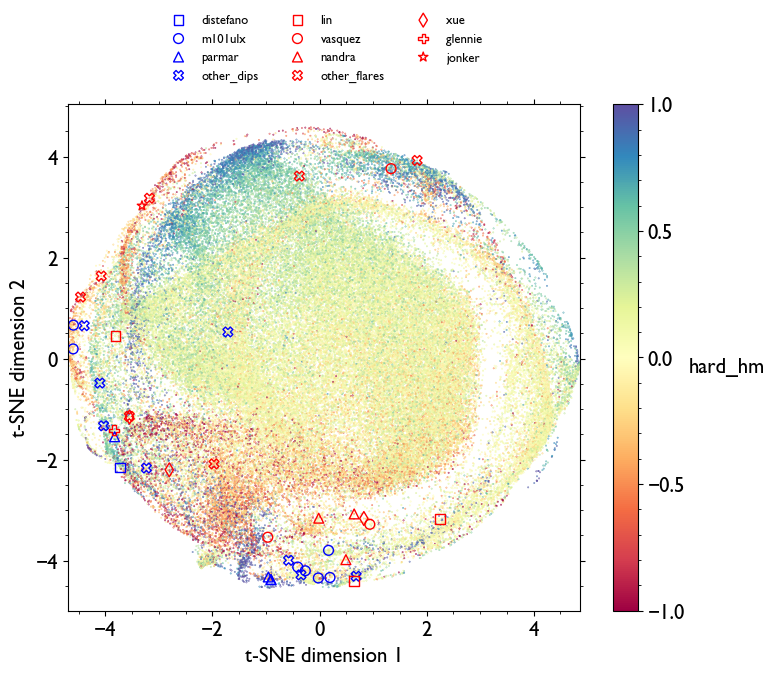

In [13]:
# Load DBSCAN 
df_dbscan = pd.read_csv(dbscan_file_widget.value)

# Plot embedding
embedding_plotter.embedding_plotter(df_dbscan, df_properties, colorcode_property_widget.value, flares_widget.value, dips_widget.value)